# IOOS Access 02: Accessing model data via the IOOS Catalog OGC CSW endpoint

**For the Pioneer Array**, https://oceanobservatories.org/array/coastal-pioneer/

- Taken from Filipe's notebook http://nbviewer.jupyter.org/gist/ocefpaf/36ab048b94859e8bf9a070db95fed174
- Builds on and parallels notebook 1

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib as mpl
import matplotlib.pyplot as plt
import folium

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
from owslib import fes

In [3]:
import shapely.geometry as shpgeom

min_lon, max_lon = -72, -69
min_lat, max_lat = 38.5, 41

pioneer_bbox_shp = shpgeom.box(min_lon, min_lat, max_lon, max_lat)
pioneer_bbox_gs = gpd.GeoSeries(pioneer_bbox_shp)

In [4]:
bbox = [min_lon, min_lat, max_lon, max_lat]
crs = 'urn:ogc:def:crs:OGC:1.3:CRS84'

bbox_crs = fes.BBox(bbox, crs=crs)

In [5]:
from datetime import datetime, timedelta
from ioos_tools.ioos import fes_date_filter

# dt = 5
dt = 25

date = datetime.utcnow()
start = date - timedelta(days=dt)
stop = date + timedelta(days=dt)

begin, end = fes_date_filter(start, stop)

/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mayorga/miniconda/envs/ioosaccess/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [6]:
cf_names = [
    'sea_water_temperature',
    'sea_surface_temperature',
    'sea_water_potential_temperature',
    'equivalent_potential_temperature',
    'sea_water_conservative_temperature',
    'pseudo_equivalent_potential_temperature',
]


kw = dict(
    wildCard='*',
    escapeChar='\\',
    singleChar='?',
    propertyname='apiso:AnyText'
)

or_filt = fes.Or(
    [fes.PropertyIsLike(literal=('*%s*' % val), **kw)
        for val in cf_names])

In [7]:
filter_list = [
    fes.And(
        [
            bbox_crs,
            begin, end,
            or_filt,
            fes.PropertyIsLike(literal=('*%s*' % 'forecast'), **kw),  # attempt at isolating model "forecasts" only
            fes.Not([fes.PropertyIsLike(literal='*cdip*', **kw)]),
            fes.Not([fes.PropertyIsLike(literal='*grib*', **kw)]),
        ]
    )
]

In [8]:
from owslib.csw import CatalogueServiceWeb
from ioos_tools.ioos import get_csw_records

endpoint = 'https://data.ioos.us/csw'

csw = CatalogueServiceWeb(endpoint, timeout=60)

get_csw_records(
    csw,
    filter_list,
    pagesize=10,
    maxrecords=1000,
    esn='full'
)

records = '\n'.join(csw.records.keys())
print('Found {} records.\n'.format(len(csw.records.keys())))

Found 5 records.



In [9]:
for key, value in list(csw.records.items()):
    print(u'[{}]\n  {}'.format(value.title, key))

[COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)]
  fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd
[Coupled Northwest Atlantic Prediction System (CNAPS)]
  edu.ncsu.meas:cnaps
[HYbrid Coordinate Ocean Model (HYCOM): Global]
  hycom_global
[ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC Averages]
  edu.rutgers.marine:roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best
[ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC History]
  edu.rutgers.marine:roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best


The scheme for selecting model forecasts yielded decent results! (But compare them to results w/o the 'forecast' filter)

In [10]:
# 'CMOP Virtual Columbia River (SELFE); f33'
#csw.records['2d_ST'].references

In [11]:
#csw.records['OCOS'].references

In [12]:
#csw.records['/opendap/hyrax/aggregated/ocean_time_aggregation.ncml'].references

In [13]:
from geolinks import sniff_link


df = []

for key, rec in csw.records.items():
    df.append(pd.DataFrame(rec.references))

df = pd.concat(df, ignore_index=True)
df['geolink'] = [sniff_link(url) for url in df['url']]

# Filtering via scheme or geolinks is completely broken at the model. The cell below perform some heuristics to figure out what is OPeNDAP and what is not.

In [14]:
df.loc[(df['scheme'] == 'OPeNDAP:OPeNDAP') | (df['geolink'] == 'OPeNDAP:OPeNDAP')]

,scheme,url,geolink
7,OPeNDAP:OPeNDAP,http://thredds.secoora.org/thredds/dodsC/SECOO...,None
17,OPeNDAP:OPeNDAP,http://oos.soest.hawaii.edu/thredds/dodsC/paci...,None
23,OPeNDAP:OPeNDAP,http://tds.marine.rutgers.edu/thredds/dodsC/ro...,None
28,OPeNDAP:OPeNDAP,http://tds.marine.rutgers.edu/thredds/dodsC/ro...,None


# With `geolinks` we got two that are the same and with `scheme` we got two but there are 4 as we can see below.

In [15]:
dap_urls = []

for i, df_row in df.iterrows():
    row = df_row.to_dict()
    # Handle the presenece of "opendap" in the COOPS obs domain
    url = row['url']
    if row['scheme'] == 'OPeNDAP:OPeNDAP' or 'dodsC' in url:
        if not '.html' in url:
            dap_urls.append(url)

In [16]:
len(dap_urls)

9

In [17]:
dap_urls

['http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best',
 '

**Can not assume that all OPeNDAP endpoints are models!**

In [18]:
from netCDF4 import Dataset
import gridgeo


grids = {}
for url in dap_urls:
    try:
        nc = Dataset(url)
    except:
        print(f'  - Could not read {url} as OPeNDAP endpoint.')
        continue

    temp = nc.get_variables_by_attributes(standard_name=lambda x: x in cf_names)[0]
    standard_name = temp.standard_name

    try:
        grid = gridgeo.GridGeo(nc, standard_name=standard_name)
        title = getattr(nc, 'title', url)
        print(f'{url}: {title}')
    except Exception:
        print(f'  - Could not get grid for {url}')
        continue
    grids.update({title: grid})

  - Could not read http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd as OPeNDAP endpoint.
http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd: COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)
  - Could not read http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc as OPeNDAP endpoint.
  - Could not read http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc as OPeNDAP endpoint.
  - Could not get grid for http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global
  - Could not read http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best as OPeNDAP endpoint.
http://tds.marine.rutgers.edu/thredds/dodsC/ro

In [19]:
grids

{'COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)': <GridGeo: unknown_2d>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC Averages': <GridGeo: sgrid>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC History': <GridGeo: sgrid>}

In [20]:
tiles = 'http://services.arcgisonline.com/arcgis/rest/services/Ocean/World_Ocean_Base/MapServer/tile/{z}/{y}/{x}'

m = folium.Map(tiles=tiles, attr='ESRI')

In [21]:
for title, grid in grids.items():
    try:
        gj = folium.GeoJson(grid.outline.__geo_interface__, name=title)
        folium.Popup(title).add_to(gj)
        gj.add_to(m)
    except Exception:
        print(f'Could not compute grid outline for {title}')

In [22]:
# Look into adding a popup? See previous cell.
# eg: folium.Popup(title).add_to(gj_element)
folium.GeoJson(pioneer_bbox_shp.__geo_interface__,
              style_function=lambda feature: {'color': 'red', 'fillOpacity': 0.0}
              ).add_to(m)

folium.LayerControl().add_to(m)

In [23]:
m.fit_bounds(m.get_bounds())

m

### Use xarray and OPeNDAP to read data from one endpoint
Explore the dataset metadata and create a simple plot.

In [24]:
import xarray as xr

In [25]:
dap_urls

['http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://omgsrv1.meas.ncsu.edu:8080/thredds/dodsC/fmrc/us_east/US_East_Forecast_Model_Run_Collection_best.ncd',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://thredds.secoora.org/thredds/dodsC/SECOORA_NCSU_CNAPS.nc',
 'http://oos.soest.hawaii.edu/thredds/dodsC/pacioos/hycom/global',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/avg/ESPRESSO_Real-Time_v2_Averages_Best',
 'http://www.ncdc.noaa.gov/oa/wct/wct-jnlp-beta.php?singlefile=http://tds.marine.rutgers.edu/thredds/dodsC/roms/espresso/2013_da/his/ESPRESSO_Real-Time_v2_History_Best',
 '

In [26]:
grids

{'COAWST Modeling System: USEast: ROMS-WRF-SWAN coupled model (aka CNAPS)': <GridGeo: unknown_2d>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC Averages': <GridGeo: sgrid>,
 'ROMS ESPRESSO Real-Time Operational IS4DVAR Forecast System Version 2 (NEW) 2013-present FMRC History': <GridGeo: sgrid>}

In [27]:
ds = xr.open_dataset(dap_urls[-1])

In [28]:
ds

<xarray.Dataset>
Dimensions:         (boundary: 4, eta_psi: 81, eta_rho: 82, eta_u: 82, eta_v: 81, ocean_time: 24, s_rho: 36, s_w: 37, time: 46068, tracer: 2, xi_psi: 129, xi_rho: 130, xi_u: 129, xi_v: 130)
Coordinates:
  * s_rho           (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 ...
  * s_w             (s_w) float64 -1.0 -0.9722 -0.9444 -0.9167 -0.8889 ...
    lon_rho         (eta_rho, xi_rho) float64 ...
    lat_rho         (eta_rho, xi_rho) float64 ...
    lon_u           (eta_u, xi_u) float64 ...
    lat_u           (eta_u, xi_u) float64 ...
    lon_v           (eta_v, xi_v) float64 ...
    lat_v           (eta_v, xi_v) float64 ...
    lon_psi         (eta_psi, xi_psi) float64 ...
    lat_psi         (eta_psi, xi_psi) float64 ...
  * ocean_time      (ocean_time) datetime64[ns] 2018-06-04T01:00:00 ...
  * time            (time) datetime64[ns] 2013-05-19T01:00:00 ...
    time_run        (time) datetime64[ns] ...
Dimensions without coordinates: boundary, eta_psi, eta_rho

In [29]:
ds.salt

<xarray.DataArray 'salt' (time: 46068, s_rho: 36, eta_rho: 82, xi_rho: 130)>
[17679055680 values with dtype=float32]
Coordinates:
  * s_rho     (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 -0.8472 ...
    lon_rho   (eta_rho, xi_rho) float64 ...
    lat_rho   (eta_rho, xi_rho) float64 ...
  * time      (time) datetime64[ns] 2013-05-19T01:00:00 2013-05-19T02:00:00 ...
    time_run  (time) datetime64[ns] ...
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:      salinity
    time:           ocean_time
    field:          salinity, scalar, series
    _ChunkSizes:    [  1  36  82 130]
    standard_name:  sea_water_salinity

In [30]:
ds.s_rho

<xarray.DataArray 's_rho' (s_rho: 36)>
array([-0.986111, -0.958333, -0.930556, -0.902778, -0.875   , -0.847222,
       -0.819444, -0.791667, -0.763889, -0.736111, -0.708333, -0.680556,
       -0.652778, -0.625   , -0.597222, -0.569444, -0.541667, -0.513889,
       -0.486111, -0.458333, -0.430556, -0.402778, -0.375   , -0.347222,
       -0.319444, -0.291667, -0.263889, -0.236111, -0.208333, -0.180556,
       -0.152778, -0.125   , -0.097222, -0.069444, -0.041667, -0.013889])
Coordinates:
  * s_rho    (s_rho) float64 -0.9861 -0.9583 -0.9306 -0.9028 -0.875 -0.8472 ...
Attributes:
    units:                     
    long_name:                 S-coordinate at RHO-points
    valid_min:                 -1.0
    valid_max:                 0.0
    positive:                  up
    standard_name:             ocean_s_coordinate_g1
    formula_terms:             s: s_rho C: Cs_r eta: zeta depth: h depth_c: hc
    field:                     s_rho, scalar
    _CoordinateTransformType:  Vertical
    _

In [31]:
ds.time_run

<xarray.DataArray 'time_run' (time: 46068)>
array(['2013-05-18T00:00:00.000000000', '2013-05-18T00:00:00.000000000',
       '2013-05-18T00:00:00.000000000', ..., '2018-08-14T00:00:00.000000000',
       '2018-08-14T00:00:00.000000000', '2018-08-14T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time      (time) datetime64[ns] 2013-05-19T01:00:00 2013-05-19T02:00:00 ...
    time_run  (time) datetime64[ns] 2013-05-18 2013-05-18 2013-05-18 ...
Attributes:
    long_name:            run times for coordinate = time
    standard_name:        forecast_reference_time
    _CoordinateAxisType:  RunTime

**NOTE: The date in `ocean_time` should be automatically set to something like today + 1 days, so it always works with forecast models.** Also, could plan on doing two, side by side plots, from different depths (s_rho values)

In [32]:
ds.time.min(), ds.time.max()

(<xarray.DataArray 'time' ()>
 array('2013-05-19T01:00:00.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'time' ()>
 array('2018-08-20T12:00:00.000000000', dtype='datetime64[ns]'))

In [36]:
# use of sel(time='2018-08-16T20:00:00', s_rho=-0.041667) is leading to a "key error", so I'm switching to isel
x = ds.salt.sel(time='2018-08-16T20:00:00').isel(s_rho=-1) # ds.salt.sel(time='2018-08-16T20:00:00', s_rho=-0.041667)

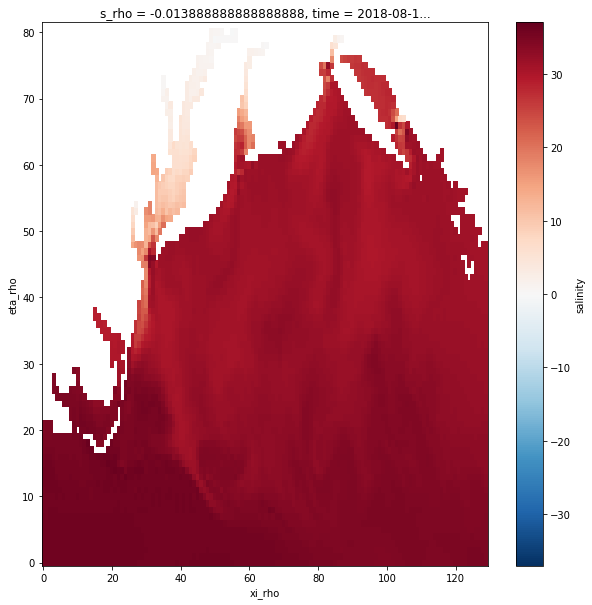

In [37]:
# hmm, there may be a no-data flag that's not properly set. The color map is not optimal, for that reason
x.plot(figsize=(10,10))